In [1]:
import pandas as pd
import seaborn as sns

In [117]:
# import pbp_since_2017.csv

pbp = pd.read_csv('../data/processed/pbp_since_2017.csv')

/tmp/ipykernel_14399/734002857.py:3: DtypeWarning: Columns (180,181,183,184,190,191,194,195,198,199,204,205,206,207,210,211,214,215,219,220,221,223,225,227,234,235,236,237,238,239,244,245,246,249,250,254,255,256,261,263,264,267,268,269,270,284,285,302,304,307,333) have mixed types. Specify dtype option on import or set low_memory=False.
  pbp = pd.read_csv('../data/processed/pbp_since_2017.csv')


In [118]:
cols_to_keep = [
    'play_id',
    'game_id',
    'home_team',
    'away_team',
    'posteam',
    'defteam',
    'season',
    'game_half',
    'week',
    'score_differential',
    'score_differential_post',
    'qtr',
    'game_seconds_remaining',
    'sp'
]

pbp_subset = pbp[cols_to_keep]

In [119]:
# isolate plays where the half is overtime
overtime_plays = pbp_subset[pbp_subset['game_half'] == 'Overtime']

In [120]:
overtime_plays

,play_id,game_id,home_team,away_team,posteam,defteam,season,game_half,week,score_differential,score_differential_post,qtr,game_seconds_remaining,sp
2819,4307.0,2017_02_ARI_IND,IND,ARI,IND,ARI,2017,Overtime,2,0.0,0.0,5.0,600.0,0.0
2820,4331.0,2017_02_ARI_IND,IND,ARI,IND,ARI,2017,Overtime,2,0.0,0.0,5.0,595.0,0.0
2821,4357.0,2017_02_ARI_IND,IND,ARI,ARI,IND,2017,Overtime,2,0.0,0.0,5.0,587.0,0.0
2822,4380.0,2017_02_ARI_IND,IND,ARI,ARI,IND,2017,Overtime,2,0.0,0.0,5.0,555.0,0.0
2823,4401.0,2017_02_ARI_IND,IND,ARI,ARI,IND,2017,Overtime,2,0.0,0.0,5.0,519.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314501,4135.0,2021_21_CIN_KC,KC,CIN,NaN,NaN,2021,Overtime,21,NaN,NaN,5.0,652.0,0.0
314502,4163.0,2021_21_CIN_KC,KC,CIN,CIN,KC,2021,Overtime,21,0.0,0.0,5.0,652.0,0.0
314503,4184.0,2021_21_CIN_KC,KC,CIN,CIN,KC,2021,Overtime,21,0.0,0.0,5.0,607.0,0.0
314504,4216.0,2021_21_CIN_KC,KC,CIN,CIN,KC,2021,Overtime,21,0.0,3.0,5.0,566.0,1.0


In [143]:

def add_seconds_since_start(df):
    # function that takes the output of get_team_data as an input
    # returns the dataframe with extra columns for seconds since start of the game
    # seconds since start of the game = 3600 - game_seconds_remaining if game_half = 'HALF1' or 'HALF2'. If game_half = 'Overtime', then seconds since start of the game = 3600 + 600 - game_seconds_remaining

    # create a new column for seconds since start of the game
    df['seconds_since_start'] = 0

    # if game_half is 'HALF1' or 'HALF2', then seconds since start of the game = 3600 - game_seconds_remaining
    df.loc[df['game_half'].isin(['Half1', 'Half2']), 'seconds_since_start'] = 3600 - df['game_seconds_remaining']

    # if game_half is 'Overtime', then seconds since start of the game = 3600 + 600 - game_seconds_remaining
    df.loc[df['game_half'] == 'Overtime', 'seconds_since_start'] = 3600 + 600 - df['game_seconds_remaining']
    
    # add another column for seconds since start of season by multiplying the week number by the seconds since the start of the game
    # df['seconds_since_start_of_season'] = df['week'] * 3600 + df['seconds_since_start']
    
    return df

In [144]:
def get_team_data(year_start, year_finish, team, df):
    # function to get that team's pbp data for the years specified
    # returns a dataframe with the data
    # year_start and year_finish are integers
    # team is a string

    # get the pbp data for the years specified
    years = range(year_start, year_finish + 1)
    pbp_years = df[df['season'].isin(years)]

    # get the pbp data for the team specified (team is either home or away team)
    pbp_team = pbp_years[(pbp_years['posteam'] == team) | (pbp_years['defteam'] == team)]

    pbp_team = add_seconds_since_start(pbp_team)

    # add a column for the team score differential based on score_differential_post
    # if the team is the posteam, then the score differential is equal to score_diffential_post
    # if the team is the defteam, then the score differential is the negative of score_differential_post

    pbp_team['team_score_differential'] = 0

    pbp_team.loc[pbp_team['posteam'] == team, 'team_score_differential'] = pbp_team['score_differential_post']
    pbp_team.loc[pbp_team['defteam'] == team, 'team_score_differential'] = -pbp_team['score_differential_post']

    return pbp_team

In [145]:
# create pbp dataframe but filter out any game_half that is 'Overtime'
pbp_no_overtime = pbp[pbp['game_half'] != 'Overtime']

df = get_team_data(2023, 2023, 'NYJ', pbp_no_overtime)

/tmp/ipykernel_14399/2650399136.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['seconds_since_start'] = 0
/tmp/ipykernel_14399/848922072.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbp_team['team_score_differential'] = 0


In [146]:
cols_to_keep = [
    'play_id',
    'game_id',
    'home_team',
    'away_team',
    'posteam',
    'defteam',
    'season',
    'game_half',
    'week',
    'score_differential',
    'score_differential_post',
    'qtr',
    'game_seconds_remaining',
    'sp',
    'seconds_since_start',
    'seconds_since_start_of_season',
    'team_score_differential'
]

df_subset = df[cols_to_keep]
df_subset

KeyError: "['seconds_since_start_of_season'] not in index"

/home/jagord24/anaconda3/envs/nflstats/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jagord24/anaconda3/envs/nflstats/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jagord24/anaconda3/envs/nflstats/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='seconds_since_start', ylabel='team_score_differential'>

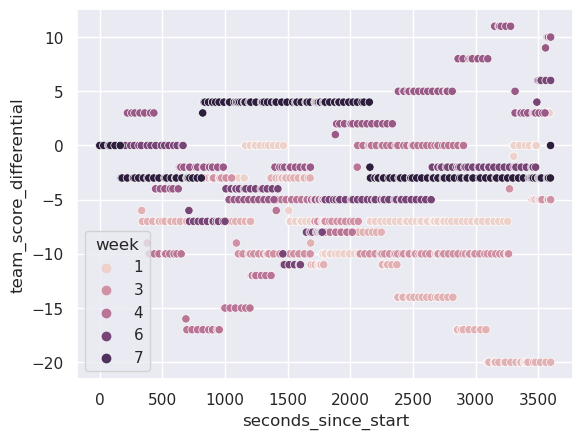

In [147]:
# scatterplot of x = seconds_since_start and y = team_score_differential

sns.scatterplot(x = 'seconds_since_start', y = 'team_score_differential', hue='week', data = df_subset)

/home/jagord24/anaconda3/envs/nflstats/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jagord24/anaconda3/envs/nflstats/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jagord24/anaconda3/envs/nflstats/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='play_id', ylabel='seconds_since_start_of_season'>

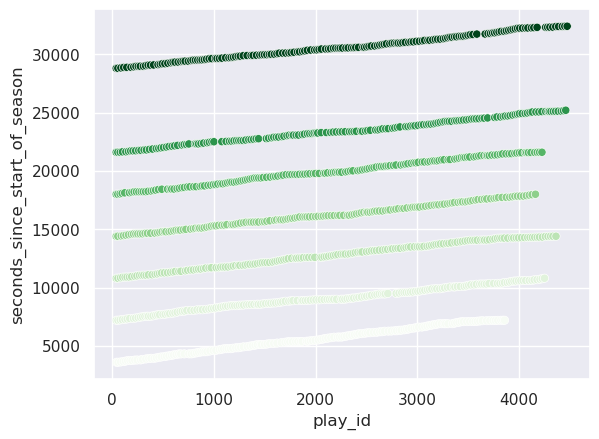

In [148]:
# plot play_id on x axis and seconds_since_start_of_season on y axis

sns.scatterplot(
    data=df_subset,
    x="play_id", y="seconds_since_start_of_season",
    hue="week", palette="Greens",
    legend=False
)

In [149]:
# create a dataframe with the data for the NYJ for the 2023 season
df_jets = get_team_data(2023, 2023, 'NYJ', pbp_no_overtime)


/tmp/ipykernel_14399/2650399136.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['seconds_since_start'] = 0
/tmp/ipykernel_14399/848922072.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbp_team['team_score_differential'] = 0


In [160]:
'''
columns:
    year, week, quarter, game_second, season_second, team, team_score, opponent_score
'''

def empty_game(year, week, team):
    # create dataframe with the following columns: year, week, quarter, game_second, season_second, team, opponent
    # there should be a row for each regulation second of an NFL game
    # the season second will be the week number * 3600 + game_second

    # create a list of the seconds in a game
    seconds = range(0, 3601)

    # create a dataframe with the seconds as the index
    df = pd.DataFrame(index = seconds)

    # add a column for the year
    df['year'] = year

    # add a column for the week
    df['week'] = week

    # add a column for the game second
    df['game_second'] = df.index

    # add a column for the season second
    df['season_second'] = (df['week'] - 1) * 3600 + df['game_second']

    # add a column for the team
    df['team'] = team

    # add a column for the opponent
    df['opponent'] = None

    # add a column for the team score
    df['team_score'] = None

    # add a column for the opponent score
    df['opponent_score'] = None

    return df

In [161]:
def get_max_week(year, team, pbp):
    # return the max number of weeks that the team played in the year specified from the pbp data
    # year is an integer
    # team is a string
    # pbp is a dataframe

    # get the pbp data for the year specified
    pbp_year = pbp[pbp['season'] == year]

    # get the pbp data for the team specified (team is either home or away team)
    pbp_team = pbp_year[(pbp_year['posteam'] == team) | (pbp_year['defteam'] == team)]

    # get the max week number
    max_week = pbp_team['week'].max()

    return max_week

In [162]:
# create a dataframe using the empty_game function and get_max_week function to create a dataframe with the data for the NYJ for the 2023 season
# run empty_game for each week so far of the season and concatenate the dataframes together

# create an empty dataframe
df_jets = pd.DataFrame()

# get the max week number for the NYJ for the 2023 season
max_week = get_max_week(2023, 'NYJ', pbp_no_overtime)

# loop through each week and run empty_game for each week
for week in range(1, max_week + 1):
    df_jets = pd.concat([df_jets, empty_game(2023, week, 'NYJ')])

df_jets

,year,week,game_second,season_second,team,opponent,team_score,opponent_score
0,2023,1,0,0,NYJ,None,None,None
1,2023,1,1,1,NYJ,None,None,None
2,2023,1,2,2,NYJ,None,None,None
3,2023,1,3,3,NYJ,None,None,None
4,2023,1,4,4,NYJ,None,None,None
...,...,...,...,...,...,...,...,...
3596,2023,8,3596,28796,NYJ,None,None,None
3597,2023,8,3597,28797,NYJ,None,None,None
3598,2023,8,3598,28798,NYJ,None,None,None
3599,2023,8,3599,28799,NYJ,None,None,None


In [163]:
# from the pbp_no_overtime dataframe, get the data for the NYJ for the 2023 season to fill in the df_jets dataframe

# get the pbp data for the NYJ for the 2023 season
df_jets_pbp = get_team_data(2023, 2023, 'NYJ', pbp_no_overtime)

# loop through each row of the df_jets_pbp dataframe and fill in the df_jets dataframe

for index, row in df_jets_pbp.iterrows():
    # get the game_second
    game_second = row['game_seconds_remaining']

    # get the season_second
    season_second = row['seconds_since_start_of_season']

    # get the team
    team = row['posteam']

    # get the opponent
    opponent = row['defteam']

    # get the team_score
    team_score = row['score_differential_post']

    # get the opponent_score
    opponent_score = -row['score_differential_post']

    # fill in the df_jets dataframe
    df_jets.loc[df_jets['season_second'] == season_second, 'opponent'] = opponent
    df_jets.loc[df_jets['season_second'] == season_second, 'team_score'] = team_score
    df_jets.loc[df_jets['season_second'] == season_second, 'opponent_score'] = opponent_score

df_jets

/tmp/ipykernel_14399/2650399136.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['seconds_since_start'] = 0
/tmp/ipykernel_14399/848922072.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbp_team['team_score_differential'] = 0


KeyError: 'seconds_since_start_of_season'

In [164]:
df_jets_pbp 

,Unnamed: 0,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,...,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe,seconds_since_start,team_score_differential
192595,192595,42.0,2023_01_BUF_NYJ,2023091100,NYJ,BUF,REG,1,BUF,away,...,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
192596,192596,58.0,2023_01_BUF_NYJ,2023091100,NYJ,BUF,REG,1,BUF,away,...,0.473129,0.488686,4.216651,2.0,0.614690,0.233894,0.485597,51.440343,0,0
192597,192597,83.0,2023_01_BUF_NYJ,2023091100,NYJ,BUF,REG,1,BUF,away,...,0.367488,1.643031,9.983959,8.0,0.558477,0.558477,0.362543,63.745666,26,0
192598,192598,108.0,2023_01_BUF_NYJ,2023091100,NYJ,BUF,REG,1,BUF,away,...,-0.266491,NaN,NaN,NaN,NaN,NaN,0.474029,-47.402874,59,0
192599,192599,130.0,2023_01_BUF_NYJ,2023091100,NYJ,BUF,REG,1,BUF,away,...,-0.530428,NaN,NaN,NaN,NaN,NaN,0.640098,-64.009839,96,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213424,213424,4364.0,2023_08_NYJ_NYG,2023102905,NYG,NYJ,REG,8,NYG,home,...,-2.848253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3572,-3
213425,213425,4392.0,2023_08_NYJ_NYG,2023102905,NYG,NYJ,REG,8,NYJ,away,...,0.873143,0.661863,8.312418,4.0,1.000000,1.000000,0.979590,2.041006,3576,-3
213426,213426,4428.0,2023_08_NYJ_NYG,2023102905,NYG,NYJ,REG,8,NYJ,away,...,1.118004,0.670246,5.861606,3.0,1.000000,1.000000,0.988920,1.107985,3583,-3
213427,213427,4453.0,2023_08_NYJ_NYG,2023102905,NYG,NYJ,REG,8,NYJ,away,...,0.628184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3598,-3


In [165]:
for index, row in df_jets_pbp.iterrows():

    # get the week
    week = row['week']

    # get the game_second
    game_second = 3600 - row['game_seconds_remaining']

    # get the season_second
    season_second = (row['week'] - 1) * 3600 + game_second

    # get the opponent
    home_team = row['home_team']
    if home_team == 'NYJ':
        opponent = row['away_team']
        team_score = row['total_home_score']
        opponent_score = row['total_away_score']
    else:
        opponent = row['home_team']
        team_score = row['total_away_score']
        opponent_score = row['total_home_score']
    
    df_jets.loc[df_jets['season_second'] == season_second, 'opponent'] = opponent
    df_jets.loc[df_jets['season_second'] == season_second, 'team_score'] = team_score
    df_jets.loc[df_jets['season_second'] == season_second, 'opponent_score'] = opponent_score

In [166]:
df_jets.head(n=100)

,year,week,game_second,season_second,team,opponent,team_score,opponent_score
0,2023,1,0,0,NYJ,BUF,0.0,0.0
1,2023,1,1,1,NYJ,None,None,None
2,2023,1,2,2,NYJ,None,None,None
3,2023,1,3,3,NYJ,None,None,None
4,2023,1,4,4,NYJ,None,None,None
...,...,...,...,...,...,...,...,...
95,2023,1,95,95,NYJ,None,None,None
96,2023,1,96,96,NYJ,BUF,0.0,0.0
97,2023,1,97,97,NYJ,None,None,None
98,2023,1,98,98,NYJ,None,None,None


In [167]:
# populate all None values in df_jets columns "opponnet", "team_score", "opponent_score" with the value from the prior row until encountering a row with data

df_jets['opponent'] = df_jets['opponent'].fillna(method='ffill')
df_jets['team_score'] = df_jets['team_score'].fillna(method='ffill')
df_jets['opponent_score'] = df_jets['opponent_score'].fillna(method='ffill')

/tmp/ipykernel_14399/1397775179.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_jets['opponent'] = df_jets['opponent'].fillna(method='ffill')
/tmp/ipykernel_14399/1397775179.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_jets['team_score'] = df_jets['team_score'].fillna(method='ffill')
/tmp/ipykernel_14399/1397775179.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_jets['opponent_score'] = df_jets['opponent_score'].fillna(method='ffill')


In [170]:
df_jets['game_score_differential'] = df_jets['team_score'] - df_jets['opponent_score']

In [183]:
# add column to df_jets that is boolean in the row is the first of a new game, and false otherwise
# first row of a game is defined as the first row of a game where the opponent is not the same as the prior row

df_jets['first_row_of_game'] = False

df_jets.loc[df_jets['opponent'] != df_jets['opponent'].shift(1), 'first_row_of_game'] = True

/home/jagord24/anaconda3/envs/nflstats/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jagord24/anaconda3/envs/nflstats/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jagord24/anaconda3/envs/nflstats/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jagord24/anaconda3/envs/nflstats/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and

<Axes: xlabel='game_second', ylabel='game_score_differential'>

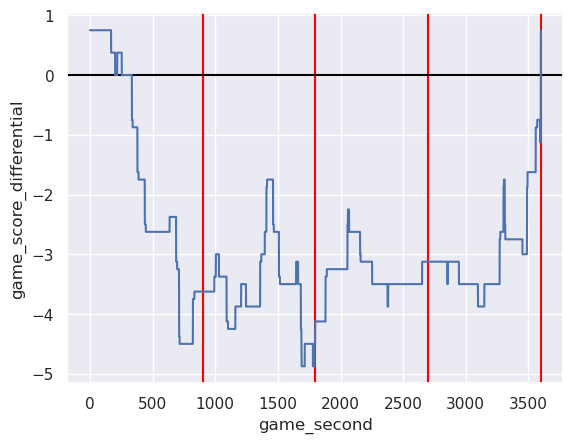

: 

In [184]:
# create a plot x axis is game_second and y axis should be the average score differential for that second
# add vertical lines for the start of each quarter (900 second increments)
# add a horizontal line for y = 0

# create a dataframe with the average score differential for each second of the game
df_jets_avg_score_differential = df_jets.groupby('game_second')['game_score_differential'].mean().reset_index()


# add vertical lines for the start of each quarter (900 second increments)
import matplotlib.pyplot as plt

plt.axvline(x=900, color='red')
plt.axvline(x=1800, color='red')
plt.axvline(x=2700, color='red')
plt.axvline(x=3600, color='red')

# add a horizontal line for y = 0
plt.axhline(y=0, color='black')

# create a plot x axis is game_second and y axis should be the average score differential for that second
sns.lineplot(x = 'game_second', y = 'game_score_differential', data = df_jets_avg_score_differential)
# create a plot x axis is game_second and y axis should be the average score differential for that second
# add vertical lines for the start of each quarter (900 second increments)
# add a horizontal line for y = 0
# add a vertical line for the start of each game
